# Modelagem dos dados

In [1]:
import math
import keras
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn import preprocessing

Using TensorFlow backend.


### Leitura dos dados

In [2]:
df = pd.read_csv("./../winequality.csv", sep=";")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Vejamos os tipos de dados de cada coluna

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   object 
 12  quality               6497 non-null   int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 660.0+ KB


### TRATAMENTO DO BANCO DE DADOS

Se observado os dados type e alcohol são objects, precisamos só trabalhar com números.

* type: object (vamos mudar para inteiro)
* alcohol: object (vamos mudar para float e eliminar dados incosistentes)

In [4]:
#adicionar números como representantes das categorias
df['type'] = df['type'].map( {'White': 1, 'Red': 0} ).astype(int)
#vamos corrigir os erros da coluna, e substituí-los para NaN, em seguida preencher essas lacunas com a moda
#poderiamos ignorá-los, mas cada dado é valioso e vamos investigar usando essas dados corrompidos
df['alcohol'] = pd.to_numeric(df['alcohol'], errors='coerce')
freq_port = df.alcohol.dropna().mode()[0]
df['alcohol'] = df['alcohol'].fillna(freq_port)

### Agora os dados são apenas números!!!

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


In [6]:
df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,1,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,1,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,0,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
6494,0,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,0,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Para começar a análise, vamos ver como a distribuição dos dados se dá

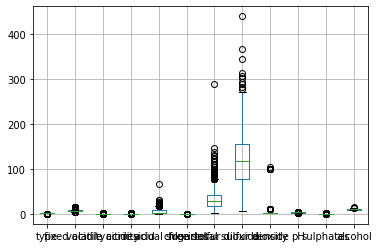

In [7]:
df.boxplot(column=list(df.columns[:-1]))

### Percebe-se que alguns atributos tem valores discrepantes, para melhorar essa visualização e não enviesar nossos modelos (alguns podem ser enviesados por essa discrepâcia de valores), vamos normalizar esses dados.

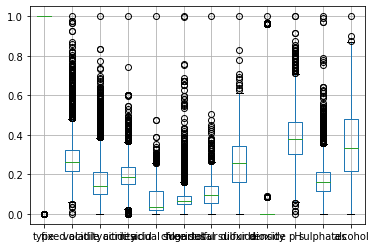

In [8]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled, columns=df.columns)
df_normalized['quality'] = df['quality']
df = df_normalized

df.boxplot(column=list(df.columns[:-1]))

### Como podem ver, alguns atributos tem outliers, vamos remove-los.

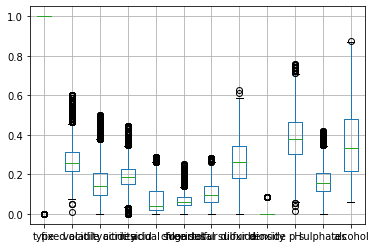

In [9]:
#REMOVER OUTLIERS
z_scores = stats.zscore(df) #calculate z-scores of `df` média 0 desvio padrão 1
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_without_outliers = df[filtered_entries]

df_without_outliers.boxplot(column=list(df.columns[:-1]))

In [10]:
df_without_outliers[['quality', 'type']].groupby(['quality'], as_index=False).mean().sort_values(by='quality', ascending=False)

,quality,type
4,8,0.929348
3,7,0.847953
2,6,0.802587
1,5,0.714066
0,4,0.836957


### Ao remover os outliers, percebemos que os dados de qualidade 3 e 9 são removidos, então eles são relevantes e devem permanecer junto com os dados.

### Agora vamos ver como o atributo quality está distribuido na coluna type novamente, mas com outra perspectiva.

In [11]:
df[['quality', 'type']].groupby(['quality'], as_index=False).mean().sort_values(by='quality', ascending=False)

,quality,type
6,9,1.000000
5,8,0.906736
4,7,0.815570
3,6,0.775035
2,5,0.681478
1,4,0.754630
0,3,0.666667


### Atributo type parece mostrar que a incidência de vinhos de qualidade maior estão mais presentes no vinho branco. Isso se deve também a quantidade de vinhos Brancos que são sua maioria.

### Vamos interpretar atributo por atributo.

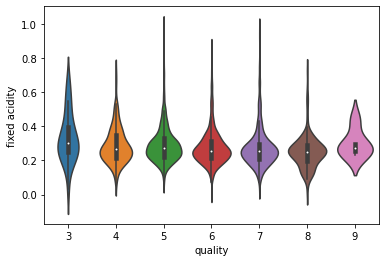

In [12]:
ax = sns.violinplot(x="quality", y="fixed acidity", data=df)

### Esse atributo não parece ser muito descritivo porém, para os casos de qualidade 3 e 9, eles se dirvegem com uma barriga maior (maior frequência dos dados) nos vinhos de alta qualidade.

### Vamos ao próximo atributo.

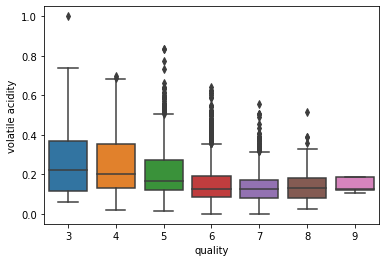

In [13]:
ax = sns.boxplot(x="quality", y="volatile acidity", data=df)

### Esse atributo já mostrou uma variedada correlacionada a qualidade, apesar de pouca.

### Interessante atributo, correlação decrescente

### Vamos ao próximo:

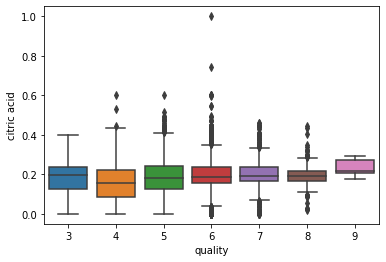

In [14]:
ax = sns.boxplot(x="quality", y="citric acid", data=df)

### Isoladamente não parece um bom atributo, mas podemos ver quando ele se combina com outro, sempre que isso ocorre, separamos esses casos para aumentar ou diminuir a dimensionalidade e verificar correlações, por enquanto mantemos.

### Segue o residual sugar

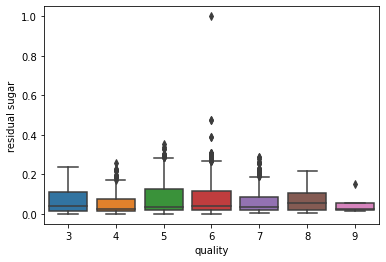

In [15]:
ax = sns.boxplot(x="quality", y="residual sugar", data=df)

### Mesma situação do anterior citric acid

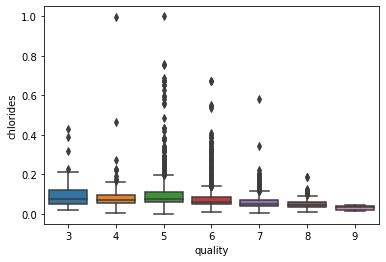

In [16]:
ax = sns.boxplot(x="quality", y="chlorides", data=df)

### Sutilmente os vinhos com mais qualidade estão em um intervalo mais curto

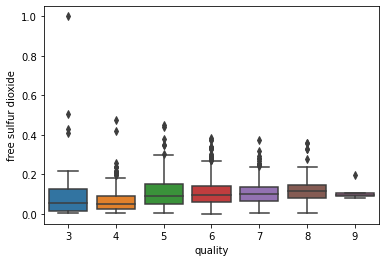

In [17]:
ax = sns.boxplot(x="quality", y="free sulfur dioxide", data=df)

### Sutil correlação decrescente e estreitamento do intervalo em vinhos com mais qualidade.

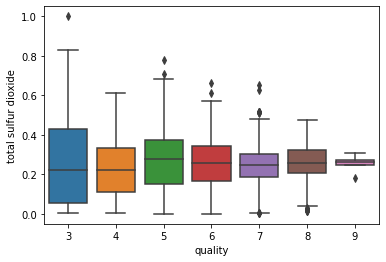

In [18]:
ax = sns.boxplot(x="quality", y="total sulfur dioxide", data=df)

### Algumas características só aparecem em vinhos com qualidade inferior, o intervalo fica mais concentrados a medida que a qualidade aumenta.

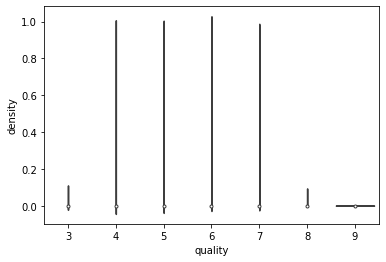

In [19]:
ax = sns.violinplot(x="quality", y="density", data=df)

### Variação inconsistente, os valores aparecem sem seguir crescente estável, nesses casos vamos categorizar por alguns intervalos.

In [24]:
# vamos categorizar, agrupar alguns intervalos
df.loc[ df['density'] <= 0.2, 'density'] = 0
df.loc[(df['density'] > 0.2) & (df['density'] <= 0.6), 'density'] = 0.5
df.loc[ df['density'] > 0.6, 'density'] = 1
df['density'] = df['density'].astype(int)
df[['quality', 'density']].groupby(['quality'], as_index=False).mean().sort_values(by='quality', ascending=False)

,quality,density
6,9,0.000000
5,8,0.000000
4,7,0.002780
3,6,0.005289
2,5,0.008887
1,4,0.004630
0,3,0.000000


### Vinhos com densidade maior são representados com pior qualidade, com algumas exceções, inclusivo para os vinhos de pior qualidade, o que dificulta na discriminação da amostra.

### Vamos a próxima característica:

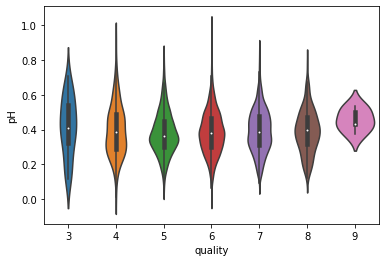

In [21]:
ax = sns.violinplot(x="quality", y="pH", data=df)

### Quanto maior a qualidade, mais restrito são os valores aceitáveis de ph do vinho

### Vamos a próxima característica:

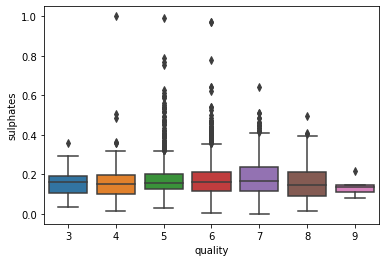

In [25]:
ax = sns.boxplot(x="quality", y="sulphates", data=df)

### Não parece ser um bom atributo, porém delimita subconjuntos simples (3 e 9), (7 e 8) e (4, 5 e 6)

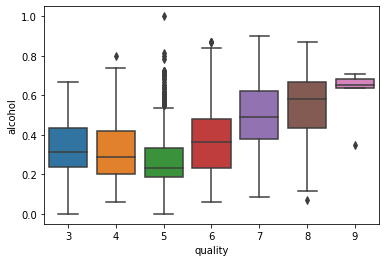

In [26]:
ax = sns.boxplot(x="quality", y="alcohol", data=df)

### Ótimo atributo, mostra-se bom representante para bons vinhos

# Machine Learning

In [28]:
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

### Vamos selecionar nossas técnicas

In [29]:
machine_learning_techniques = []
machine_learning_techniques.append(SVC())
machine_learning_techniques.append(LinearSVC())
machine_learning_techniques.append(RandomForestClassifier())
machine_learning_techniques.append(KNeighborsClassifier())
machine_learning_techniques.append(GaussianNB())
machine_learning_techniques.append(Perceptron())
machine_learning_techniques.append(SGDClassifier())
machine_learning_techniques.append(DecisionTreeClassifier())
machine_learning_techniques.append(MultinomialNB())

### Embaralhar nossa amostra

In [31]:
df = df.sample(frac=1).reset_index(drop=True)

### Treinar e avaliar nossos modelos

In [32]:
for tech in machine_learning_techniques:

    # cross 10-fold validation
    interval = int(len(df)/10)
    total_acc = []
    total_rmse = []
    for i in range(0, len(df)-interval, interval):

        test_df = df.loc[i:i+interval]
        if i+interval > len(df)-interval:
            test_df = df.loc[i:]

        train_df = df.drop(test_df.index)
        # Balanceamento não melhorou a predição dos modelos e por isso não foi utilizado, seguimos com a distribuição reais dos dados.
        # train_df = balancing(train_df)

        X_test = test_df.drop("quality", axis=1)
        Y_test = test_df["quality"]

        X_train = train_df.drop("quality", axis=1)
        Y_train = train_df["quality"]

        # treina
        tech.fit(X_train, Y_train)
        
        # predição e acc
        Y_pred = tech.predict(X_test)
        
        acc_tech = round(tech.score(X_test, Y_test) * 100, 2)
        mse = mean_squared_error(Y_test, Y_pred)
        # print(f'acc: {acc_tech} mse:{mse}')
        total_acc.append(acc_tech)
        total_rmse.append(mse)

    acc_mean = sum(total_acc)/len(total_acc)
    rmse_mean = sum(total_rmse)/len(total_rmse)
    print(f'acc: {round(acc_mean, 2)}% - rmse: {round(rmse_mean, 2)} {tech.__class__.__name__}')

acc: 54.12 - rmse: 0.65 SVC
acc: 52.95 - rmse: 0.67 LinearSVC
acc: 70.14 - rmse: 0.41 RandomForestClassifier
acc: 58.07 - rmse: 0.63 KNeighborsClassifier
acc: 2.08 - rmse: 6.52 GaussianNB
acc: 42.5 - rmse: 1.17 Perceptron
acc: 51.69 - rmse: 0.72 SGDClassifier
acc: 62.88 - rmse: 0.67 DecisionTreeClassifier
acc: 43.78 - rmse: 0.79 MultinomialNB


# Deep Learning

In [36]:
import keras
import keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt

from keras.utils import np_utils

### Definição do modelo

In [47]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='elu', input_shape=(12,)),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(16, activation='elu'),
    keras.layers.Dense(7, activation='softmax')
])

### Criação de uma callback

In [39]:
from keras.callbacks import Callback

class TerminateTrainingLoss(Callback):

    """
    Termina o treino quando atinge determinada loss
    """

    def __init__(self, minimal_loss=0.2):
        self.minimal_loss = minimal_loss

    def on_epoch_end(self, epoch, logs=None, verbose=False):
        
        if logs.get('loss') < self.minimal_loss:
            self.model.stop_training = True

### Criação de uma loss function para observação

In [48]:
def RMSE(y_true, y_pred):
    # Um pouco diferente da abordagem do sklearn por que utiliza das probabilidades da softmax 
    # (não comparável até que se utilizem a mesma abordagem para avaliação)
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

adam = keras.optimizers.Adam(learning_rate=0.004)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['acc', RMSE])

### Preparação dos dados

In [43]:
df = df.sample(frac=1).reset_index(drop=True)
interval = int(len(df)/10)
print(f'interval: {interval}')

test_df = df.loc[:interval]
train_df = df.drop(test_df.index)
# Balanceamento não melhorou a predição dos modelos e por isso não foi utilizado, seguimos com a distribuição reais dos dados.
# train_df = balancing(train_df)

# Como parte do pré processamento vamos transformar o label em matriz identidade
# por isso vamos simplificar o valor desse resultado para um intervalo melhor aceitável
# entre 0 e 7 e não entre 3 e 9
X_test = test_df.drop("quality", axis=1)
Y_test = test_df["quality"]-3

X_train = train_df.drop("quality", axis=1)
Y_train = train_df["quality"]-3

print(np_utils.to_categorical(Y_test).shape)

interval: 649
(650, 6)


### Treino e avaliação do modelo

In [49]:
# callback
callback = TerminateTrainingLoss()

# treina
history = model.fit(X_train, 
                    np_utils.to_categorical(Y_train, num_classes=7), 
                    epochs=1000, 
                    callbacks=[callback],
                    verbose=1, 
                    batch_size=128, 
                    validation_split = 0.1)

# predição e acc e mse
_, acc_tech, _ = model.evaluate(X_test, 
                            np_utils.to_categorical(Y_test, num_classes=7), 
                            verbose=0)

print(f'\nDeep learning trouxe uma acurácia de {round(acc_tech,2)}\n')

Train on 5262 samples, validate on 585 samples
Epoch 1/1000
5262/5262 [==============================] - 1s 199us/step - loss: 1.2607 - acc: 0.4491 - RMSE: 0.3054 - val_loss: 1.1169 - val_acc: 0.5077 - val_RMSE: 0.2933
Epoch 2/1000
5262/5262 [==============================] - 0s 20us/step - loss: 1.1133 - acc: 0.5300 - RMSE: 0.2911 - val_loss: 1.0948 - val_acc: 0.5368 - val_RMSE: 0.2925
Epoch 3/1000
5262/5262 [==============================] - 0s 15us/step - loss: 1.1071 - acc: 0.5325 - RMSE: 0.2918 - val_loss: 1.0706 - val_acc: 0.5197 - val_RMSE: 0.2904
Epoch 4/1000
5262/5262 [==============================] - 0s 16us/step - loss: 1.0908 - acc: 0.5429 - RMSE: 0.2897 - val_loss: 1.0824 - val_acc: 0.5470 - val_RMSE: 0.2914
Epoch 5/1000
5262/5262 [==============================] - 0s 15us/step - loss: 1.0898 - acc: 0.5376 - RMSE: 0.2907 - val_loss: 1.0782 - val_acc: 0.5026 - val_RMSE: 0.2919
Epoch 6/1000
5262/5262 [==============================] - 0s 15us/step - loss: 1.0928 - acc: 0.54

5262/5262 [==============================] - 0s 14us/step - loss: 1.0019 - acc: 0.5696 - RMSE: 0.2813 - val_loss: 1.0151 - val_acc: 0.5538 - val_RMSE: 0.2830
Epoch 49/1000
5262/5262 [==============================] - 0s 15us/step - loss: 0.9943 - acc: 0.5743 - RMSE: 0.2819 - val_loss: 1.0127 - val_acc: 0.5470 - val_RMSE: 0.2828
Epoch 50/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.9912 - acc: 0.5718 - RMSE: 0.2807 - val_loss: 1.0142 - val_acc: 0.5607 - val_RMSE: 0.2847
Epoch 51/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.9893 - acc: 0.5726 - RMSE: 0.2805 - val_loss: 1.0073 - val_acc: 0.5504 - val_RMSE: 0.2837
Epoch 52/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.9812 - acc: 0.5741 - RMSE: 0.2786 - val_loss: 1.0110 - val_acc: 0.5573 - val_RMSE: 0.2823
Epoch 53/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.9825 - acc: 0.5810 - RMSE: 0.2796 - val_loss: 1.0248 - val_acc: 0.5675 -

Epoch 96/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.8976 - acc: 0.6100 - RMSE: 0.2690 - val_loss: 1.0311 - val_acc: 0.5880 - val_RMSE: 0.2816
Epoch 97/1000
5262/5262 [==============================] - 0s 15us/step - loss: 0.8910 - acc: 0.6135 - RMSE: 0.2672 - val_loss: 1.0635 - val_acc: 0.5624 - val_RMSE: 0.2850
Epoch 98/1000
5262/5262 [==============================] - 0s 15us/step - loss: 0.8905 - acc: 0.6176 - RMSE: 0.2671 - val_loss: 1.0675 - val_acc: 0.5573 - val_RMSE: 0.2861
Epoch 99/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.8870 - acc: 0.6233 - RMSE: 0.2667 - val_loss: 1.0676 - val_acc: 0.5556 - val_RMSE: 0.2849
Epoch 100/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.8945 - acc: 0.6112 - RMSE: 0.2683 - val_loss: 1.0565 - val_acc: 0.5829 - val_RMSE: 0.2836
Epoch 101/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.8880 - acc: 0.6163 - RMSE: 0.2682 - val_loss: 1.0618 - v

5262/5262 [==============================] - 0s 15us/step - loss: 0.8154 - acc: 0.6539 - RMSE: 0.2560 - val_loss: 1.0810 - val_acc: 0.5897 - val_RMSE: 0.2805
Epoch 144/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.7912 - acc: 0.6604 - RMSE: 0.2543 - val_loss: 1.0766 - val_acc: 0.5624 - val_RMSE: 0.2827
Epoch 145/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.7799 - acc: 0.6684 - RMSE: 0.2516 - val_loss: 1.0978 - val_acc: 0.5573 - val_RMSE: 0.2847
Epoch 146/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.7909 - acc: 0.6646 - RMSE: 0.2519 - val_loss: 1.1229 - val_acc: 0.5658 - val_RMSE: 0.2851
Epoch 147/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.7855 - acc: 0.6670 - RMSE: 0.2525 - val_loss: 1.1030 - val_acc: 0.5761 - val_RMSE: 0.2822
Epoch 148/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.7676 - acc: 0.6703 - RMSE: 0.2512 - val_loss: 1.1072 - val_acc: 0.5

5262/5262 [==============================] - 0s 14us/step - loss: 0.6710 - acc: 0.7146 - RMSE: 0.2352 - val_loss: 1.1753 - val_acc: 0.6017 - val_RMSE: 0.2800
Epoch 191/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.7540 - acc: 0.6843 - RMSE: 0.2470 - val_loss: 1.2026 - val_acc: 0.5692 - val_RMSE: 0.2859
Epoch 192/1000
5262/5262 [==============================] - 0s 15us/step - loss: 0.7023 - acc: 0.7054 - RMSE: 0.2396 - val_loss: 1.2023 - val_acc: 0.5761 - val_RMSE: 0.2860
Epoch 193/1000
5262/5262 [==============================] - 0s 16us/step - loss: 0.6897 - acc: 0.7106 - RMSE: 0.2376 - val_loss: 1.1617 - val_acc: 0.5863 - val_RMSE: 0.2793
Epoch 194/1000
5262/5262 [==============================] - 0s 16us/step - loss: 0.6743 - acc: 0.7119 - RMSE: 0.2359 - val_loss: 1.1771 - val_acc: 0.5880 - val_RMSE: 0.2813
Epoch 195/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.6689 - acc: 0.7189 - RMSE: 0.2339 - val_loss: 1.1751 - val_acc: 0.6

5262/5262 [==============================] - 0s 15us/step - loss: 0.6169 - acc: 0.7395 - RMSE: 0.2251 - val_loss: 1.3069 - val_acc: 0.5915 - val_RMSE: 0.2899
Epoch 238/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.6105 - acc: 0.7374 - RMSE: 0.2239 - val_loss: 1.3293 - val_acc: 0.5897 - val_RMSE: 0.2921
Epoch 239/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.6130 - acc: 0.7328 - RMSE: 0.2259 - val_loss: 1.2846 - val_acc: 0.6017 - val_RMSE: 0.2868
Epoch 240/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.6115 - acc: 0.7400 - RMSE: 0.2258 - val_loss: 1.3368 - val_acc: 0.5846 - val_RMSE: 0.2892
Epoch 241/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.6651 - acc: 0.7199 - RMSE: 0.2336 - val_loss: 1.2992 - val_acc: 0.5812 - val_RMSE: 0.2886
Epoch 242/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.6386 - acc: 0.7267 - RMSE: 0.2288 - val_loss: 1.2975 - val_acc: 0.5

5262/5262 [==============================] - 0s 18us/step - loss: 0.5464 - acc: 0.7714 - RMSE: 0.2129 - val_loss: 1.5201 - val_acc: 0.5846 - val_RMSE: 0.2910
Epoch 285/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.5215 - acc: 0.7832 - RMSE: 0.2065 - val_loss: 1.4916 - val_acc: 0.6051 - val_RMSE: 0.2913
Epoch 286/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.5419 - acc: 0.7685 - RMSE: 0.2114 - val_loss: 1.4911 - val_acc: 0.5726 - val_RMSE: 0.2926
Epoch 287/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.5582 - acc: 0.7647 - RMSE: 0.2162 - val_loss: 1.5526 - val_acc: 0.5829 - val_RMSE: 0.2975
Epoch 288/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.7757 - acc: 0.6914 - RMSE: 0.2437 - val_loss: 1.3749 - val_acc: 0.5915 - val_RMSE: 0.2889
Epoch 289/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.6967 - acc: 0.7125 - RMSE: 0.2376 - val_loss: 1.4263 - val_acc: 0.5

5262/5262 [==============================] - 0s 13us/step - loss: 0.5741 - acc: 0.7592 - RMSE: 0.2165 - val_loss: 1.6345 - val_acc: 0.5812 - val_RMSE: 0.2940
Epoch 332/1000
5262/5262 [==============================] - 0s 15us/step - loss: 0.5123 - acc: 0.7862 - RMSE: 0.2044 - val_loss: 1.6439 - val_acc: 0.5692 - val_RMSE: 0.2984
Epoch 333/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.5162 - acc: 0.7780 - RMSE: 0.2074 - val_loss: 1.6971 - val_acc: 0.5692 - val_RMSE: 0.2980
Epoch 334/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.5299 - acc: 0.7828 - RMSE: 0.2098 - val_loss: 1.6711 - val_acc: 0.5915 - val_RMSE: 0.2956
Epoch 335/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.5167 - acc: 0.7847 - RMSE: 0.2050 - val_loss: 1.6284 - val_acc: 0.5812 - val_RMSE: 0.2951
Epoch 336/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.5255 - acc: 0.7828 - RMSE: 0.2069 - val_loss: 1.6717 - val_acc: 0.5

5262/5262 [==============================] - 0s 13us/step - loss: 0.4751 - acc: 0.7999 - RMSE: 0.1979 - val_loss: 1.7310 - val_acc: 0.6051 - val_RMSE: 0.2945
Epoch 379/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.5146 - acc: 0.7904 - RMSE: 0.2029 - val_loss: 1.7853 - val_acc: 0.5641 - val_RMSE: 0.3028
Epoch 380/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4776 - acc: 0.8018 - RMSE: 0.1981 - val_loss: 1.7411 - val_acc: 0.6000 - val_RMSE: 0.2955
Epoch 381/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4690 - acc: 0.8018 - RMSE: 0.1972 - val_loss: 1.7903 - val_acc: 0.5726 - val_RMSE: 0.3006
Epoch 382/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.4671 - acc: 0.8056 - RMSE: 0.1952 - val_loss: 1.7747 - val_acc: 0.6000 - val_RMSE: 0.2985
Epoch 383/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4613 - acc: 0.8090 - RMSE: 0.1966 - val_loss: 1.7365 - val_acc: 0.5

5262/5262 [==============================] - 0s 13us/step - loss: 0.4290 - acc: 0.8223 - RMSE: 0.1879 - val_loss: 1.8963 - val_acc: 0.5932 - val_RMSE: 0.3005
Epoch 426/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.4621 - acc: 0.8062 - RMSE: 0.1949 - val_loss: 1.9165 - val_acc: 0.5949 - val_RMSE: 0.3021
Epoch 427/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.4391 - acc: 0.8101 - RMSE: 0.1915 - val_loss: 1.8545 - val_acc: 0.6034 - val_RMSE: 0.2954
Epoch 428/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4897 - acc: 0.7963 - RMSE: 0.1995 - val_loss: 1.8055 - val_acc: 0.5744 - val_RMSE: 0.3000
Epoch 429/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4510 - acc: 0.8111 - RMSE: 0.1939 - val_loss: 1.8955 - val_acc: 0.5795 - val_RMSE: 0.3029
Epoch 430/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.5382 - acc: 0.7809 - RMSE: 0.2076 - val_loss: 1.9280 - val_acc: 0.5

5262/5262 [==============================] - 0s 14us/step - loss: 0.4509 - acc: 0.8181 - RMSE: 0.1915 - val_loss: 2.1150 - val_acc: 0.5863 - val_RMSE: 0.3053
Epoch 473/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.4351 - acc: 0.8198 - RMSE: 0.1898 - val_loss: 1.9464 - val_acc: 0.6000 - val_RMSE: 0.2970
Epoch 474/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4148 - acc: 0.8244 - RMSE: 0.1851 - val_loss: 2.0554 - val_acc: 0.6000 - val_RMSE: 0.2979
Epoch 475/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4641 - acc: 0.8109 - RMSE: 0.1956 - val_loss: 2.0788 - val_acc: 0.5880 - val_RMSE: 0.3004
Epoch 476/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4538 - acc: 0.8174 - RMSE: 0.1904 - val_loss: 2.1066 - val_acc: 0.5880 - val_RMSE: 0.3048
Epoch 477/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.5077 - acc: 0.7913 - RMSE: 0.2017 - val_loss: 1.9288 - val_acc: 0.5

5262/5262 [==============================] - 0s 13us/step - loss: 0.3762 - acc: 0.8470 - RMSE: 0.1755 - val_loss: 2.2047 - val_acc: 0.5966 - val_RMSE: 0.3027
Epoch 520/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.3915 - acc: 0.8360 - RMSE: 0.1795 - val_loss: 2.1111 - val_acc: 0.5932 - val_RMSE: 0.3000
Epoch 521/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.3738 - acc: 0.8459 - RMSE: 0.1748 - val_loss: 2.1992 - val_acc: 0.5880 - val_RMSE: 0.3026
Epoch 522/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.3748 - acc: 0.8400 - RMSE: 0.1764 - val_loss: 2.1882 - val_acc: 0.5829 - val_RMSE: 0.3028
Epoch 523/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.3864 - acc: 0.8388 - RMSE: 0.1801 - val_loss: 2.3282 - val_acc: 0.5829 - val_RMSE: 0.3097
Epoch 524/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.4166 - acc: 0.8267 - RMSE: 0.1869 - val_loss: 2.2354 - val_acc: 0.5

5262/5262 [==============================] - 0s 13us/step - loss: 0.4548 - acc: 0.8214 - RMSE: 0.1920 - val_loss: 2.2300 - val_acc: 0.5709 - val_RMSE: 0.3039
Epoch 567/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4373 - acc: 0.8166 - RMSE: 0.1909 - val_loss: 2.2780 - val_acc: 0.5829 - val_RMSE: 0.3060
Epoch 568/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.5826 - acc: 0.7968 - RMSE: 0.2041 - val_loss: 2.2327 - val_acc: 0.5692 - val_RMSE: 0.3062
Epoch 569/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4742 - acc: 0.8111 - RMSE: 0.1932 - val_loss: 2.2292 - val_acc: 0.5829 - val_RMSE: 0.3034
Epoch 570/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.4087 - acc: 0.8322 - RMSE: 0.1824 - val_loss: 2.2651 - val_acc: 0.5863 - val_RMSE: 0.3015
Epoch 571/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.3717 - acc: 0.8499 - RMSE: 0.1743 - val_loss: 2.2232 - val_acc: 0.5

5262/5262 [==============================] - 0s 12us/step - loss: 0.3618 - acc: 0.8476 - RMSE: 0.1732 - val_loss: 2.3135 - val_acc: 0.5932 - val_RMSE: 0.3019
Epoch 614/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.4261 - acc: 0.8292 - RMSE: 0.1825 - val_loss: 2.5294 - val_acc: 0.5761 - val_RMSE: 0.3108
Epoch 615/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.4440 - acc: 0.8231 - RMSE: 0.1884 - val_loss: 2.3905 - val_acc: 0.5966 - val_RMSE: 0.2975
Epoch 616/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3768 - acc: 0.8426 - RMSE: 0.1758 - val_loss: 2.3728 - val_acc: 0.5897 - val_RMSE: 0.3020
Epoch 617/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3708 - acc: 0.8445 - RMSE: 0.1744 - val_loss: 2.3380 - val_acc: 0.5880 - val_RMSE: 0.3023
Epoch 618/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3503 - acc: 0.8544 - RMSE: 0.1714 - val_loss: 2.4456 - val_acc: 0.6

5262/5262 [==============================] - 0s 11us/step - loss: 0.3520 - acc: 0.8540 - RMSE: 0.1727 - val_loss: 2.3200 - val_acc: 0.5932 - val_RMSE: 0.3008
Epoch 661/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3446 - acc: 0.8594 - RMSE: 0.1690 - val_loss: 2.3636 - val_acc: 0.5846 - val_RMSE: 0.3049
Epoch 662/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3091 - acc: 0.8721 - RMSE: 0.1583 - val_loss: 2.3607 - val_acc: 0.5880 - val_RMSE: 0.3032
Epoch 663/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3029 - acc: 0.8757 - RMSE: 0.1598 - val_loss: 2.3554 - val_acc: 0.5932 - val_RMSE: 0.3027
Epoch 664/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3801 - acc: 0.8537 - RMSE: 0.1736 - val_loss: 2.4919 - val_acc: 0.5761 - val_RMSE: 0.3068
Epoch 665/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.4035 - acc: 0.8368 - RMSE: 0.1790 - val_loss: 2.4400 - val_acc: 0.6

5262/5262 [==============================] - 0s 13us/step - loss: 0.3361 - acc: 0.8674 - RMSE: 0.1671 - val_loss: 2.4089 - val_acc: 0.5880 - val_RMSE: 0.3036
Epoch 708/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.3771 - acc: 0.8413 - RMSE: 0.1762 - val_loss: 2.5040 - val_acc: 0.6120 - val_RMSE: 0.2972
Epoch 709/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.3238 - acc: 0.8679 - RMSE: 0.1619 - val_loss: 2.4921 - val_acc: 0.5897 - val_RMSE: 0.3024
Epoch 710/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.2883 - acc: 0.8888 - RMSE: 0.1529 - val_loss: 2.5368 - val_acc: 0.5966 - val_RMSE: 0.3032
Epoch 711/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.2905 - acc: 0.8835 - RMSE: 0.1559 - val_loss: 2.5037 - val_acc: 0.6051 - val_RMSE: 0.2998
Epoch 712/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.4001 - acc: 0.8415 - RMSE: 0.1802 - val_loss: 2.5278 - val_acc: 0.5

5262/5262 [==============================] - 0s 13us/step - loss: 0.4384 - acc: 0.8282 - RMSE: 0.1864 - val_loss: 2.5049 - val_acc: 0.5863 - val_RMSE: 0.3057
Epoch 755/1000
5262/5262 [==============================] - 0s 14us/step - loss: 0.3382 - acc: 0.8639 - RMSE: 0.1666 - val_loss: 2.6438 - val_acc: 0.6017 - val_RMSE: 0.3020
Epoch 756/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.3267 - acc: 0.8672 - RMSE: 0.1631 - val_loss: 2.6016 - val_acc: 0.5983 - val_RMSE: 0.3023
Epoch 757/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.3171 - acc: 0.8715 - RMSE: 0.1581 - val_loss: 2.5316 - val_acc: 0.5966 - val_RMSE: 0.3024
Epoch 758/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.2817 - acc: 0.8886 - RMSE: 0.1513 - val_loss: 2.6605 - val_acc: 0.5932 - val_RMSE: 0.3047
Epoch 759/1000
5262/5262 [==============================] - 0s 13us/step - loss: 0.2952 - acc: 0.8801 - RMSE: 0.1547 - val_loss: 2.5299 - val_acc: 0.6

5262/5262 [==============================] - 0s 12us/step - loss: 0.3752 - acc: 0.8491 - RMSE: 0.1737 - val_loss: 2.6430 - val_acc: 0.6034 - val_RMSE: 0.3027
Epoch 802/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3394 - acc: 0.8626 - RMSE: 0.1669 - val_loss: 2.7219 - val_acc: 0.6120 - val_RMSE: 0.2995
Epoch 803/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.4014 - acc: 0.8482 - RMSE: 0.1748 - val_loss: 2.9240 - val_acc: 0.5983 - val_RMSE: 0.3040
Epoch 804/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3480 - acc: 0.8670 - RMSE: 0.1646 - val_loss: 2.8167 - val_acc: 0.6000 - val_RMSE: 0.3048
Epoch 805/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3362 - acc: 0.8649 - RMSE: 0.1635 - val_loss: 2.9087 - val_acc: 0.5761 - val_RMSE: 0.3130
Epoch 806/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.4457 - acc: 0.8333 - RMSE: 0.1858 - val_loss: 2.7999 - val_acc: 0.5

5262/5262 [==============================] - 0s 11us/step - loss: 0.2872 - acc: 0.8833 - RMSE: 0.1528 - val_loss: 2.9739 - val_acc: 0.5966 - val_RMSE: 0.3075
Epoch 849/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.2889 - acc: 0.8829 - RMSE: 0.1541 - val_loss: 2.9529 - val_acc: 0.6000 - val_RMSE: 0.3058
Epoch 850/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.4555 - acc: 0.8311 - RMSE: 0.1827 - val_loss: 3.0087 - val_acc: 0.5744 - val_RMSE: 0.3108
Epoch 851/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.7900 - acc: 0.7607 - RMSE: 0.2227 - val_loss: 2.7247 - val_acc: 0.5607 - val_RMSE: 0.3112
Epoch 852/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.4821 - acc: 0.8139 - RMSE: 0.1950 - val_loss: 2.8104 - val_acc: 0.5556 - val_RMSE: 0.3187
Epoch 853/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.4324 - acc: 0.8259 - RMSE: 0.1827 - val_loss: 2.9536 - val_acc: 0.5

5262/5262 [==============================] - 0s 13us/step - loss: 0.3836 - acc: 0.8453 - RMSE: 0.1746 - val_loss: 2.9769 - val_acc: 0.5812 - val_RMSE: 0.3119
Epoch 896/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3297 - acc: 0.8687 - RMSE: 0.1638 - val_loss: 2.9885 - val_acc: 0.5846 - val_RMSE: 0.3098
Epoch 897/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3221 - acc: 0.8725 - RMSE: 0.1603 - val_loss: 3.0297 - val_acc: 0.5829 - val_RMSE: 0.3094
Epoch 898/1000
5262/5262 [==============================] - 0s 12us/step - loss: 0.3083 - acc: 0.8765 - RMSE: 0.1597 - val_loss: 2.9153 - val_acc: 0.5983 - val_RMSE: 0.3070
Epoch 899/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3290 - acc: 0.8736 - RMSE: 0.1623 - val_loss: 3.1532 - val_acc: 0.6000 - val_RMSE: 0.3104
Epoch 900/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3038 - acc: 0.8776 - RMSE: 0.1583 - val_loss: 3.1143 - val_acc: 0.5

5262/5262 [==============================] - 0s 10us/step - loss: 0.3671 - acc: 0.8630 - RMSE: 0.1686 - val_loss: 2.9566 - val_acc: 0.5761 - val_RMSE: 0.3115
Epoch 943/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.5198 - acc: 0.8219 - RMSE: 0.1897 - val_loss: 2.9424 - val_acc: 0.5744 - val_RMSE: 0.3106
Epoch 944/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.3995 - acc: 0.8453 - RMSE: 0.1775 - val_loss: 3.0657 - val_acc: 0.5846 - val_RMSE: 0.3099
Epoch 945/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.3254 - acc: 0.8660 - RMSE: 0.1642 - val_loss: 3.0385 - val_acc: 0.6120 - val_RMSE: 0.3043
Epoch 946/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.3382 - acc: 0.8691 - RMSE: 0.1630 - val_loss: 2.9839 - val_acc: 0.5846 - val_RMSE: 0.3107
Epoch 947/1000
5262/5262 [==============================] - 0s 10us/step - loss: 0.3205 - acc: 0.8696 - RMSE: 0.1609 - val_loss: 3.1212 - val_acc: 0.6

5262/5262 [==============================] - 0s 11us/step - loss: 0.2741 - acc: 0.8894 - RMSE: 0.1507 - val_loss: 3.0766 - val_acc: 0.6137 - val_RMSE: 0.3067
Epoch 990/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3091 - acc: 0.8776 - RMSE: 0.1593 - val_loss: 3.1111 - val_acc: 0.5966 - val_RMSE: 0.3085
Epoch 991/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3276 - acc: 0.8677 - RMSE: 0.1607 - val_loss: 3.1154 - val_acc: 0.6051 - val_RMSE: 0.3080
Epoch 992/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.2728 - acc: 0.8903 - RMSE: 0.1482 - val_loss: 3.1437 - val_acc: 0.6068 - val_RMSE: 0.3056
Epoch 993/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.2685 - acc: 0.8926 - RMSE: 0.1510 - val_loss: 3.1202 - val_acc: 0.5761 - val_RMSE: 0.3112
Epoch 994/1000
5262/5262 [==============================] - 0s 11us/step - loss: 0.3154 - acc: 0.8719 - RMSE: 0.1587 - val_loss: 3.2055 - val_acc: 0.5

### Vamos plotar o histórico de treinamento

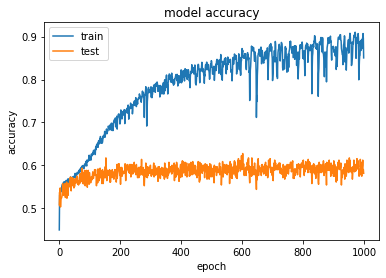

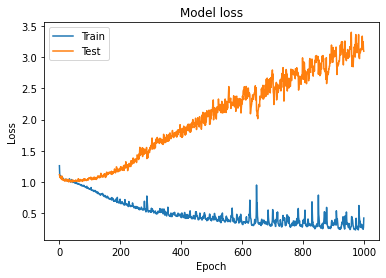

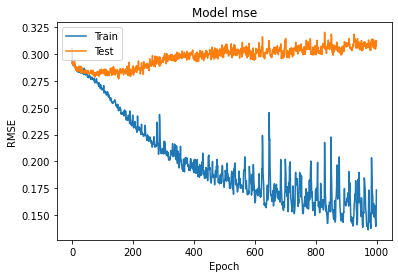

In [50]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation mse values
plt.plot(history.history['RMSE'])
plt.plot(history.history['val_RMSE'])
plt.title('Model mse')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()